# Построение моделей предсказания надоя и качества молока коров

Нужно создать модели линейной и логичтической регрессии для покупки лучших коров на ферму.

## Цель
С помощью моделей нужно отобрать коров по двум критериям:
 - средний удой за год — не менее 6000 килограммов;
 - молоко должно быть вкусным.

## Описание данных:
### Текущее стадо
- `id` — уникальный идентификатор коровы.
- `Удой, кг` — масса молока, которую корова даёт в год (в килограммах).
- `ЭКЕ (Энергетическая кормовая единица)` — показатель питательности корма коровы.
- `Сырой протеин, г` — содержание сырого протеина в корме (в граммах).
- `СПО (Сахаро-протеиновое соотношение)` — отношение сахара к протеину в корме коровы.
- `Порода` — порода коровы.
- `Тип пастбища` — ландшафт лугов, на которых паслась корова.
- `порода папы_быка` — порода папы коровы.
- `Жирность,%` — содержание жиров в молоке (в процентах).
- `Белок,%` — содержание белков в молоке (в процентах).
- `Вкус молока` — оценка вкуса по личным критериям фермера, бинарный признак (вкусно, не вкусно).
- `Возраст` — возраст коровы, бинарный признак (менее_2_лет, более_2_лет).
### Родитель коров
- `id` — уникальный идентификатор коровы.
- `Имя Папы` — имя папы коровы.
### Продаваемые коровы
- `Порода` — порода коровы.
- `Тип пастбища` — ландшафт лугов, на которых паслась корова.
- `порода папы_быка` — порода папы коровы.
- `Имя_папы` — имя папы коровы.
- `Текущая_жирность,%` — содержание жиров в молоке (в процентах).
- `Текущий_уровень_белок,%` — содержание белков в молоке (в процентах).
- `Возраст` — возраст коровы, бинарный признак (менее_2_лет, более_2_лет).

## План исследования

1) Предобработка данных
2) Исследовательский анализ данных
3) Подготовка данных к ML
4) Обучение экспериментальных моделей линейной регрессии
5) Оценка метрик
6) Промежуточные выводы
7) Подготовка данных для логистической регрессии
8) Обучение экспериментальных моделей логистической регрессии
9) Оценка метрик
10) Промежуточные выводы
10) Общие выводы

##  Предобработка данных

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from datetime import datetime as dt
import math
from scipy import stats as st
import seaborn as sns
import phik
import matplotlib.colors as clr

In [2]:
try:
    own_herd = pd.read_csv(r".\source\ferma_main.csv", sep=';')
    cows_ancestor = pd.read_csv(r".\source\ferma_dad.csv", sep=';')
    sale_herd = pd.read_csv(r".\source\cow_buy.csv", sep=';')
except:
    own_herd = pd.read_csv("/datasets/ferma_main.csv", sep=';')
    cows_ancestor = pd.read_csv("/datasets/ferma_dad.csv", sep=';')
    sale_herd = pd.read_csv("/datasets/cow_buy.csv", sep=';')

pd.set_option('display.max_columns', None)
print(f"Own heard:\n{own_herd.head(20)}")
print(f"Cows ancestors:\n{cows_ancestor.head(20)}")
print(f"Herd for sale:\n{sale_herd.head(20)}")

Own heard:
    id  Удой, кг ЭКЕ (Энергетическая кормовая единица)  Сырой протеин, г  \
0    1      5863                                  14,2              1743   
1    2      5529                                  12,8              2138   
2    3      5810                                    14              1854   
3    4      5895                                  12,4              2012   
4    5      5302                                  12,8              1675   
5    6      5254                                  12,7              1806   
6    7      5910                                  13,2              1792   
7    8      6179                                  14,7              1806   
8    9      6783                                  14,2              1918   
9   10      5339                                  13,4              1791   
10  11      5591                                  13,7              1678   
11  12      6563                                  16,5              2328   
1

Переименуем называния колонок на англоязычные, в соостветствии с конвенциональным именованием.

In [3]:
own_herd = own_herd.rename(columns={"Удой, кг": "yield",
                                    "ЭКЕ (Энергетическая кормовая единица)": "EFU",
                                    "Сырой протеин, г": "raw_protein",
                                    "СПО (Сахаро-протеиновое соотношение)": "SPR",
                                    "Порода": "breed",
                                    "Тип пастбища": "pasture_type",
                                    "порода папы_быка": "ancestor_breed",
                                    "Жирность,%": "fatness",
                                    "Белок,%": "proteins",
                                    "Вкус молока": "is_milk_tasty",
                                    "Возраст": "is_old",})
cows_ancestor = cows_ancestor.rename(columns={"Удой, кг": "yield",
                                    "Имя Папы": "ancestor_name"})
sale_herd = sale_herd.rename(columns={"Порода": "breed",
                                    "Тип пастбища": "pasture_type",
                                    "порода папы_быка": "ancestor_breed",
                                    "Имя_папы": "ancestor_name",
                                    "Текущая_жирность,%": "fatness",
                                    "Текущий_уровень_белок,%": "proteins",
                                    "Возраст": "is_old"})

In [4]:
own_herd.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 634 entries, 0 to 633
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   id              634 non-null    int64 
 1   yield           634 non-null    int64 
 2   EFU             634 non-null    object
 3   raw_protein     634 non-null    int64 
 4   SPR             634 non-null    object
 5   breed           634 non-null    object
 6   pasture_type    634 non-null    object
 7   ancestor_breed  634 non-null    object
 8   fatness         634 non-null    object
 9   proteins        634 non-null    object
 10  is_milk_tasty   634 non-null    object
 11  is_old          634 non-null    object
dtypes: int64(3), object(9)
memory usage: 59.6+ KB


In [5]:
cows_ancestor.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 629 entries, 0 to 628
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   id             629 non-null    int64 
 1   ancestor_name  629 non-null    object
dtypes: int64(1), object(1)
memory usage: 10.0+ KB


In [6]:
sale_herd.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20 entries, 0 to 19
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   breed           20 non-null     object
 1   pasture_type    20 non-null     object
 2   ancestor_breed  20 non-null     object
 3   ancestor_name   20 non-null     object
 4   fatness         20 non-null     object
 5   proteins        20 non-null     object
 6   is_old          20 non-null     object
dtypes: object(7)
memory usage: 1.2+ KB


Проверим наличие явных дубликатов.

In [7]:
def handle_duplicates(dataframe):
    duplicates_count = dataframe.duplicated().sum()

    if duplicates_count > 0:
        dataframe.drop_duplicates(inplace=True)
    
    print(f"Droped {duplicates_count} duplicates.")

In [8]:
handle_duplicates(own_herd)
handle_duplicates(cows_ancestor)
handle_duplicates(sale_herd)

Droped 5 duplicates.
Droped 0 duplicates.
Droped 4 duplicates.


Преобразуем данные к соответствующим типам.

In [9]:
def replace_fp_delimiter(columns, df):
    for col in columns:
        df[col] = df[col].str.replace(",", ".")

In [10]:
own_herd.nunique()

id                629
yield             528
EFU                55
raw_protein       401
SPR                12
breed               2
pasture_type        3
ancestor_breed      3
fatness            50
proteins           15
is_milk_tasty       2
is_old              2
dtype: int64

In [11]:
float_columns = ["EFU", "SPR", "fatness","proteins"]
replace_fp_delimiter(float_columns, own_herd)
own_herd = own_herd.astype({"EFU": "float",
                            "SPR": "float",
                            "breed": "category",
                            "pasture_type": "category",
                            "ancestor_breed": "category",
                            "fatness": "float",
                            "proteins": "float",
                            "is_milk_tasty": "category",
                            "is_old": "category"})

own_herd["is_milk_tasty"] = pd.Series([cow_milk == "вкусно" for cow_milk in own_herd["is_milk_tasty"]], dtype="category")
own_herd["is_old"] = pd.Series([cow_milk == "более_2_лет" for cow_milk in own_herd["is_old"]], dtype="category")

In [12]:
own_herd.head(1)

,id,yield,EFU,raw_protein,SPR,breed,pasture_type,ancestor_breed,fatness,proteins,is_milk_tasty,is_old
0,1,5863,14.2,1743,0.89,Вис Бик Айдиал,Равнинное,Айдиал,3.58,3.076,True,True


In [13]:
own_herd.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 629 entries, 0 to 628
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype   
---  ------          --------------  -----   
 0   id              629 non-null    int64   
 1   yield           629 non-null    int64   
 2   EFU             629 non-null    float64 
 3   raw_protein     629 non-null    int64   
 4   SPR             629 non-null    float64 
 5   breed           629 non-null    category
 6   pasture_type    629 non-null    category
 7   ancestor_breed  629 non-null    category
 8   fatness         629 non-null    float64 
 9   proteins        629 non-null    float64 
 10  is_milk_tasty   629 non-null    category
 11  is_old          629 non-null    category
dtypes: category(5), float64(4), int64(3)
memory usage: 43.0 KB


In [14]:
cows_ancestor.nunique()

id               629
ancestor_name      4
dtype: int64

In [15]:
cows_ancestor = cows_ancestor.astype({"ancestor_name": "category"})

In [16]:
cows_ancestor.head(1)

,id,ancestor_name
0,1,Буйный


In [17]:
cows_ancestor.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 629 entries, 0 to 628
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype   
---  ------         --------------  -----   
 0   id             629 non-null    int64   
 1   ancestor_name  629 non-null    category
dtypes: category(1), int64(1)
memory usage: 5.9 KB


In [18]:
sale_herd.nunique()

breed              2
pasture_type       2
ancestor_breed     2
ancestor_name      4
fatness           12
proteins          12
is_old             2
dtype: int64

In [19]:
float_columns = ["fatness","proteins"]
replace_fp_delimiter(float_columns, sale_herd)
sale_herd = sale_herd.astype({"breed": "category",
                            "pasture_type": "category",
                            "ancestor_breed": "category",
                            "ancestor_name": "category",
                            "fatness": "float",
                            "proteins": "float",
                            "is_old": "category"})

sale_herd["is_old"] = pd.Series([cow_milk == "более_2_лет" for cow_milk in sale_herd["is_old"]], dtype="category")

In [20]:
sale_herd.head(1)

,breed,pasture_type,ancestor_breed,ancestor_name,fatness,proteins,is_old
0,Вис Бик Айдиал,холмистое,Айдиал,Геркулес,3.58,3.076,True


In [21]:
sale_herd.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16 entries, 0 to 18
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype   
---  ------          --------------  -----   
 0   breed           16 non-null     category
 1   pasture_type    16 non-null     category
 2   ancestor_breed  16 non-null     category
 3   ancestor_name   16 non-null     category
 4   fatness         16 non-null     float64 
 5   proteins        16 non-null     float64 
 6   is_old          13 non-null     category
dtypes: category(5), float64(2)
memory usage: 1.1 KB


Проверим наличие пропусков в данных.

In [22]:
own_herd.isna().sum()

id                0
yield             0
EFU               0
raw_protein       0
SPR               0
breed             0
pasture_type      0
ancestor_breed    0
fatness           0
proteins          0
is_milk_tasty     0
is_old            0
dtype: int64

In [23]:
cows_ancestor.isna().sum()

id               0
ancestor_name    0
dtype: int64

In [24]:
sale_herd.isna().sum()

breed             0
pasture_type      0
ancestor_breed    0
ancestor_name     0
fatness           0
proteins          0
is_old            3
dtype: int64

## Исследовательский анализ данных

Рассмотрим описательную статистику данных.

In [25]:
own_herd.describe()

,id,yield,EFU,raw_protein,SPR,fatness,proteins
count,629.00000,629.000000,629.000000,629.000000,629.000000,629.000000,629.000000
mean,315.00000,6188.750397,14.543879,1923.364070,0.913116,3.603657,3.075671
std,181.72094,1644.795489,1.306408,182.956251,0.032203,0.168656,0.002549
min,1.00000,5204.000000,10.900000,1660.000000,0.840000,2.990000,3.069000
25%,158.00000,5751.000000,13.500000,1771.000000,0.890000,3.590000,3.074000
50%,315.00000,6133.000000,14.700000,1888.000000,0.930000,3.650000,3.076000
75%,472.00000,6501.000000,15.600000,2062.000000,0.940000,3.720000,3.077000
max,629.00000,45616.000000,16.800000,2349.000000,0.960000,3.750000,3.085000


Максимальный надой нереалистично большой. Вероятно, в данных есть выбросы.

In [26]:
sale_herd.describe()

,fatness,proteins
count,16.000000,16.000000
mean,3.571875,3.068250
std,0.141620,0.011264
min,3.340000,3.046000
25%,3.415000,3.059500
50%,3.585000,3.073500
75%,3.692500,3.076750
max,3.770000,3.081000


Для продаваемых коров количественные данные выглядят адекватно.

Далее рассмотрим в деталях каждый из признаков. Начнём с надоя.

<AxesSubplot:title={'center':'Надой коров'}, xlabel='Молока за год, кг', ylabel='Количество коров с таким надоем'>

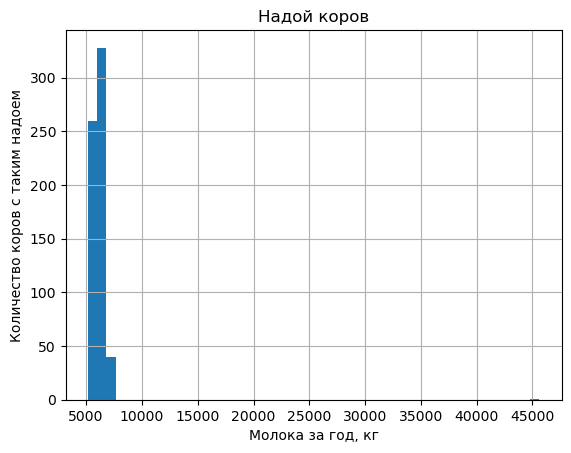

In [27]:
_, ax = plt.subplots()
ax.set_title('Надой коров')
ax.set_xlabel("Молока за год, кг")
ax.set_ylabel("Количество коров с таким надоем")
own_herd["yield"].hist(bins=50)

Удалим нереалистично большой выброс и построим график частот заново.

<AxesSubplot:title={'center':'Надой коров'}, xlabel='Молока за год, кг', ylabel='Количество коров с таким надоем'>

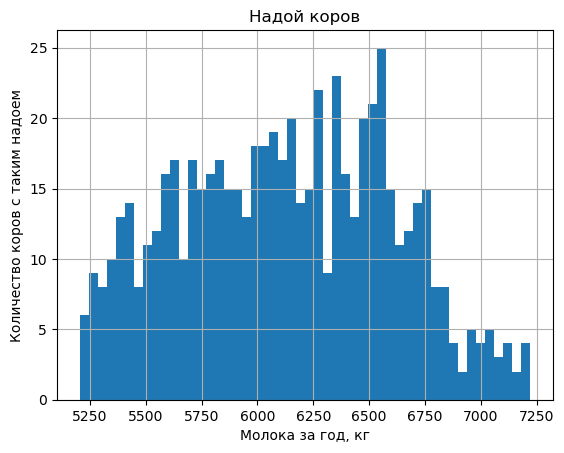

In [28]:
own_herd = own_herd[own_herd["yield"] < 15000]
_, ax = plt.subplots()
ax.set_title('Надой коров')
ax.set_xlabel("Молока за год, кг")
ax.set_ylabel("Количество коров с таким надоем")
own_herd["yield"].hist(bins=50)

Надой распределён унимодально. Коров, имеющих большие надои меньше. В целом, достаточно редко встречаются коровы с надоем больше 6900 кг в год.

<AxesSubplot:title={'center':'Питательность корма коров'}, xlabel='Питательность корма', ylabel='Количество коров с соответствующим кормом'>

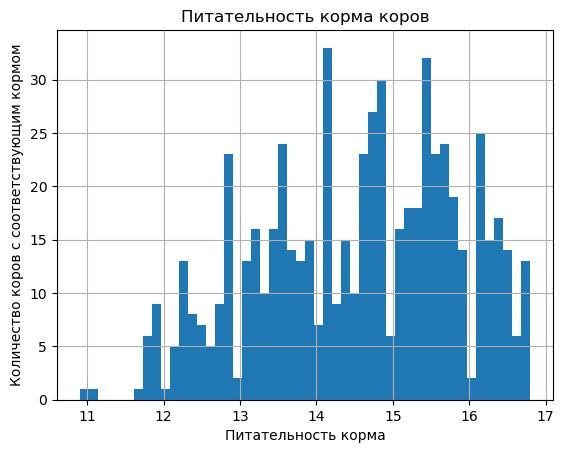

In [29]:
_, ax = plt.subplots()
ax.set_title('Питательность корма коров')
ax.set_xlabel("Питательность корма")
ax.set_ylabel("Количество коров с соответствующим кормом")
own_herd["EFU"].hist(bins=50)

На графике видно, что нескольким коровам попался корм с очень низкой энергетической ценностью. Стоит запомнить эту особенность и в дальнейшем решить, что с этим делать. Так же виден выброс, есть одна корова с крайне не питательнным кормом. Удалим её из выборки.

<AxesSubplot:title={'center':'Питательность корма коров'}, xlabel='Питательность корма', ylabel='Количество коров с соответствующим кормом'>

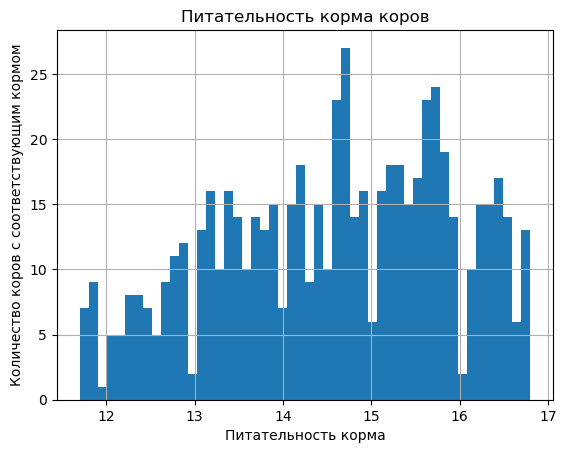

In [30]:
own_herd = own_herd[own_herd["EFU"] > 11.5]
_, ax = plt.subplots()
ax.set_title('Питательность корма коров')
ax.set_xlabel("Питательность корма")
ax.set_ylabel("Количество коров с соответствующим кормом")
own_herd["EFU"].hist(bins=50)

<AxesSubplot:title={'center':'Сахаро-протеиновое соотношение корма коров'}, xlabel='Отношение сахара к белкам', ylabel='Количество коров с соответствующим кормом'>

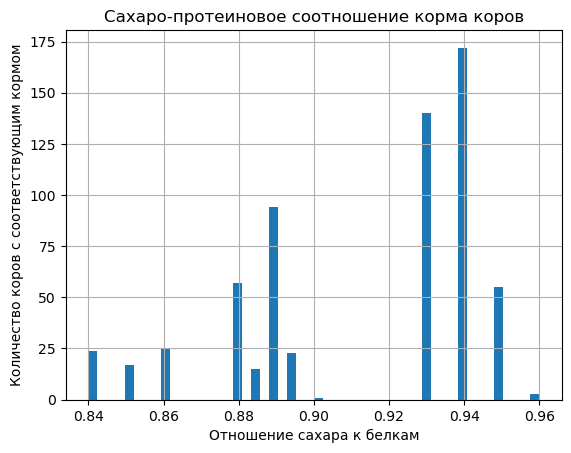

In [31]:
_, ax = plt.subplots()
ax.set_title('Сахаро-протеиновое соотношение корма коров')
ax.set_xlabel("Отношение сахара к белкам")
ax.set_ylabel("Количество коров с соответствующим кормом")
own_herd["SPR"].hist(bins=50)

Можно выделить три группы коров по сахаро-протеиновое соотношению в их корме: менее 0.87, от 0.87 до 0.91 и более 0.91. Рассмотрим как отличаются удой и вкус молока у коров из этих групп.

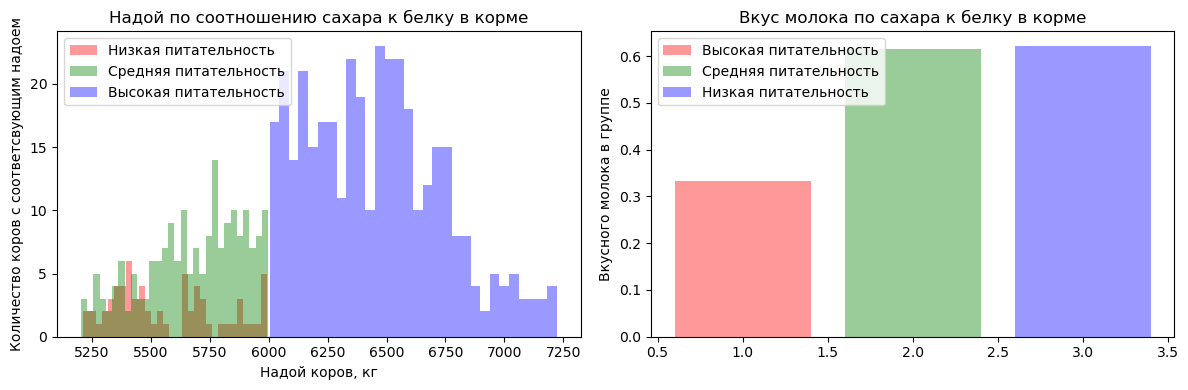

In [32]:
low_SPR = own_herd[own_herd["SPR"] < 0.87]
mid_SPR = own_herd[(own_herd["SPR"] >= 0.87) & (own_herd["SPR"] < 0.91)]
high_SPR = own_herd[own_herd["SPR"] >= 0.91]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
line11 = ax1.hist(low_SPR["yield"], bins=30, alpha = 0.4, color= 'r')
line12 = ax1.hist(mid_SPR["yield"], bins=30, alpha = 0.4, color= 'g')
line13 = ax1.hist(high_SPR["yield"], bins=30, alpha = 0.4, color= 'b')
ax1.set_title('Надой по соотношению сахара к белку в корме')
ax1.set_xlabel("Надой коров, кг")
ax1.set_ylabel("Количество коров с соответсвующим надоем")
ax1.legend(['Низкая питательность', 'Средняя питательность', 'Высокая питательность'])

line21 = ax2.bar(1, low_SPR[low_SPR["is_milk_tasty"]].shape[0] / low_SPR.shape[0], color= 'r', alpha = 0.4)
line22 = ax2.bar(2, mid_SPR[mid_SPR["is_milk_tasty"]].shape[0] / mid_SPR.shape[0], color= 'g', alpha = 0.4)
line23 = ax2.bar(3, high_SPR[high_SPR["is_milk_tasty"]].shape[0] / high_SPR.shape[0], color= 'b', alpha = 0.4)
ax2.set_title('Вкус молока по сахара к белку в корме')
ax2.set_ylabel("Вкусного молока в группе")
ax2.legend(['Высокая питательность', 'Средняя питательность', 'Низкая питательность'])

plt.tight_layout()
plt.show()

Делаем вывод что питательность корма может влиять на надой. Только корм с высокими энергетическими кормовыми единицами позволяет получить большие надои. Так же делаем вывод, что корм с низкой питательностью делает молоко невкусным.

<AxesSubplot:title={'center':'Содержание белка в корме коров'}, xlabel='Содержание белка, г', ylabel='Количество коров с соответствующим кормом'>

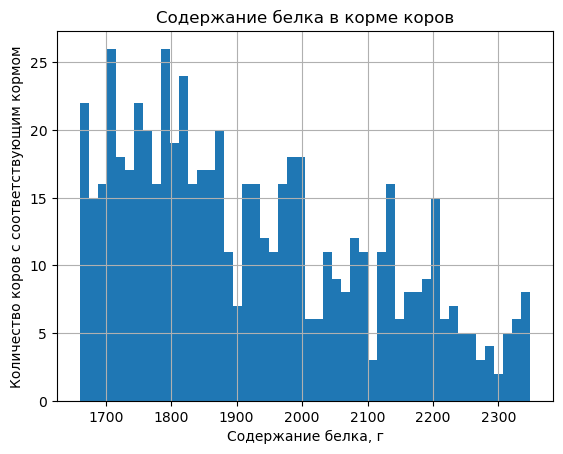

In [33]:
_, ax = plt.subplots()
ax.set_title('Содержание белка в корме коров')
ax.set_xlabel("Содержание белка, г")
ax.set_ylabel("Количество коров с соответствующим кормом")
own_herd["raw_protein"].hist(bins=50)

Видно что чаще всего коровам дают около 1750 белка в корме. Однако большая чась коров получает меньше белка в корме.

<AxesSubplot:title={'center':'Жирность молока коров'}, xlabel='Жирность молока, %', ylabel='Количество коров с соответствующей жирностью молока'>

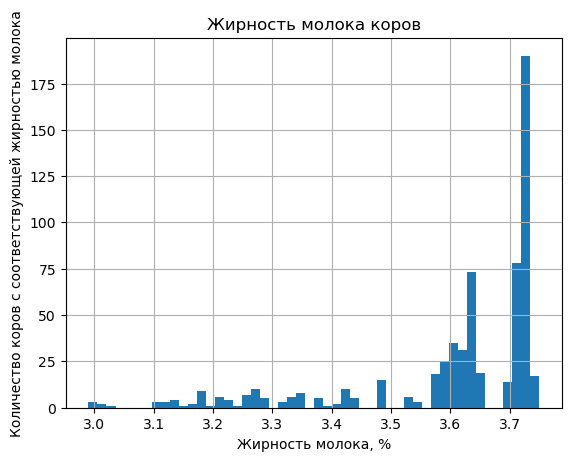

In [34]:
_, ax = plt.subplots()
ax.set_title('Жирность молока коров')
ax.set_xlabel("Жирность молока, %")
ax.set_ylabel("Количество коров с соответствующей жирностью молока")
own_herd["fatness"].hist(bins=50)

Видим, что значения жирности молока для большинства коров находятся в диапазоне 3.55% - 3.75%. Так же есть коровы, которые дают молоко с меньшей жирностью, но это редкость. Делаем вывод, что это не выбросы, т.к. таких коров достаточно много, а распределение этого признака, похоже, логнормальное.


<AxesSubplot:title={'center':'Количество белка в молоке коров'}, xlabel='Белок, %', ylabel='Количество коров с соответствующим содержанием белка в молоке'>

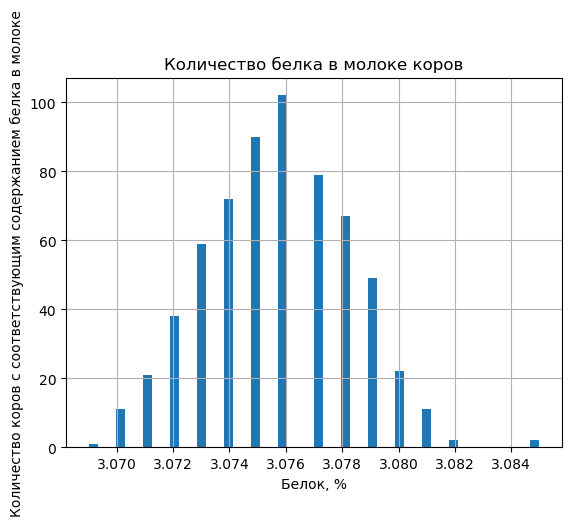

In [35]:
_, ax = plt.subplots()
ax.set_title('Количество белка в молоке коров')
ax.set_xlabel("Белок, %")
ax.set_ylabel("Количество коров с соответствующим содержанием белка в молоке")
own_herd["proteins"].hist(bins=50)

Содержание белка в молоке, похоже, распеределено нормально. Заметен выброс в сторону увеличения содержания белка. Т.к. выбросы составляют малую часть выборки по этому признаку, удалим их для лучшей стабилизации модели.

<AxesSubplot:title={'center':'Количество белка в молоке коров'}, xlabel='Белок, %', ylabel='Количество коров с соответствующим содержанием белка в молоке'>

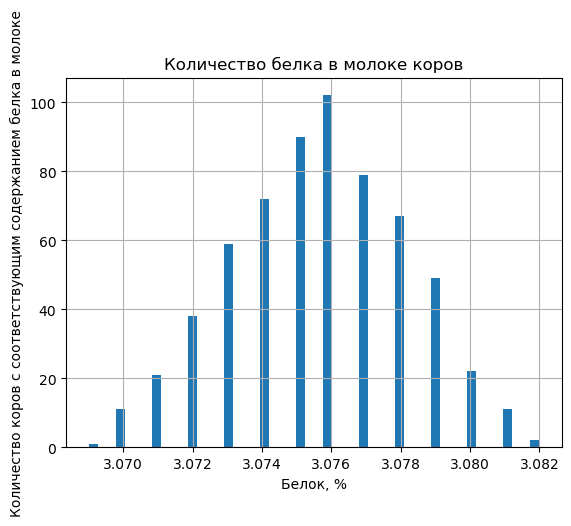

In [36]:

own_herd = own_herd[own_herd["proteins"] < 3.084]
_, ax = plt.subplots()
ax.set_title('Количество белка в молоке коров')
ax.set_xlabel("Белок, %")
ax.set_ylabel("Количество коров с соответствующим содержанием белка в молоке")
own_herd["proteins"].hist(bins=50)

Далее рассмотрим категориальные признаки.

In [37]:
own_herd.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 624 entries, 0 to 628
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype   
---  ------          --------------  -----   
 0   id              624 non-null    int64   
 1   yield           624 non-null    int64   
 2   EFU             624 non-null    float64 
 3   raw_protein     624 non-null    int64   
 4   SPR             624 non-null    float64 
 5   breed           624 non-null    category
 6   pasture_type    624 non-null    category
 7   ancestor_breed  624 non-null    category
 8   fatness         624 non-null    float64 
 9   proteins        624 non-null    float64 
 10  is_milk_tasty   624 non-null    category
 11  is_old          624 non-null    category
dtypes: category(5), float64(4), int64(3)
memory usage: 42.7 KB


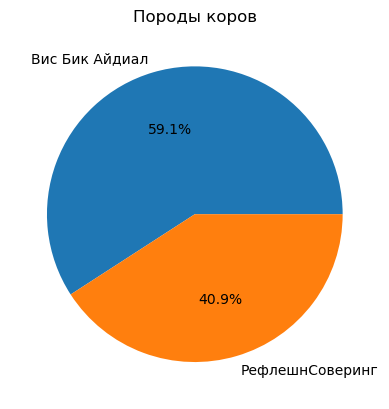

In [38]:
distribution = own_herd["breed"].value_counts()
fig, ax = plt.subplots()
ax.pie(distribution, labels = distribution.index, autopct="%1.1f%%")
ax.set_title("Породы коров")
plt.show()

В стеде фермера немного больше коров породы Вис Бик Айдиал.

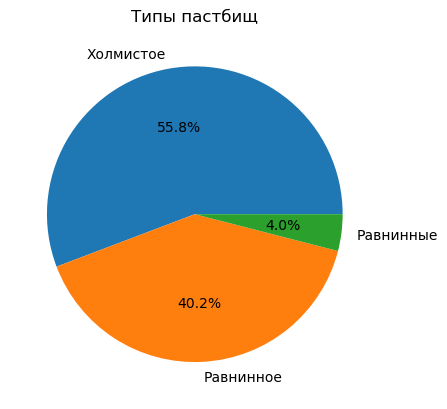

In [39]:
distribution = own_herd["pasture_type"].value_counts()
fig, ax = plt.subplots()
ax.pie(distribution, labels = distribution.index, autopct="%1.1f%%")
ax.set_title("Типы пастбищ")
plt.show()

Исправим описку и объеденим две одинаковые по сути категории.

In [40]:
own_herd["pasture_type"].dtype

CategoricalDtype(categories=['Равнинное', 'Равнинные', 'Холмистое'], ordered=False)

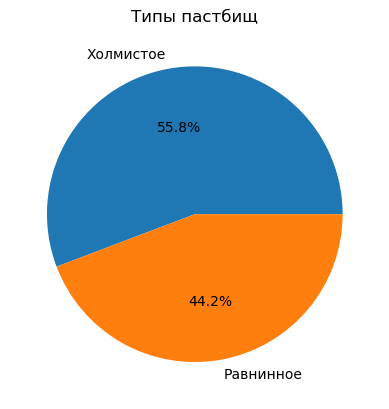

In [41]:
own_herd["pasture_type"] = own_herd["pasture_type"].apply(lambda x: "Равнинное" if x == "Равнинные" else x)
distribution = own_herd["pasture_type"].value_counts()
fig, ax = plt.subplots()
ax.pie(distribution, labels = distribution.index, autopct="%1.1f%%")
ax.set_title("Типы пастбищ")
plt.show()

Незначительно больше коров паслись на холмистых пастбищах.

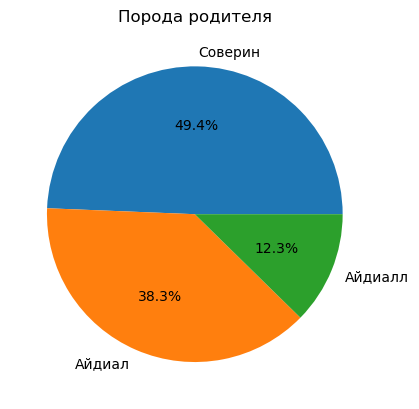

In [42]:
distribution = own_herd["ancestor_breed"].value_counts()
fig, ax = plt.subplots()
ax.pie(distribution, labels = distribution.index, autopct="%1.1f%%")
ax.set_title("Порода родителя")
plt.show()

Исправим описку и объеденим две одинаковые по сути категории.

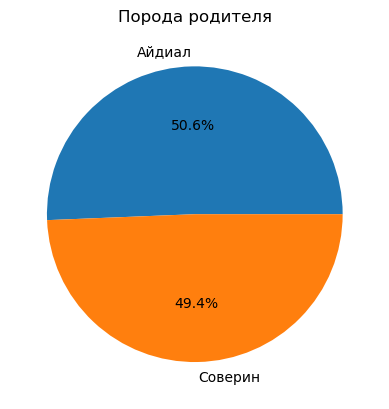

In [43]:
own_herd["ancestor_breed"] = own_herd["ancestor_breed"].apply(lambda x: "Айдиал" if x == "Айдиалл" else x)
distribution = own_herd["ancestor_breed"].value_counts()
fig, ax = plt.subplots()
ax.pie(distribution, labels = distribution.index, autopct="%1.1f%%")
ax.set_title("Порода родителя")
plt.show()

Почти одинаковое количество коров в стаде имеют происхождение Соверин и Айдиал.

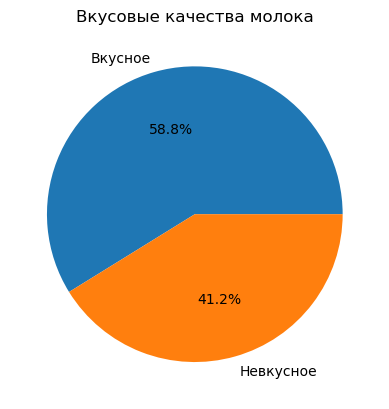

In [44]:
distribution = own_herd["is_milk_tasty"].value_counts()
fig, ax = plt.subplots()
ax.pie(distribution, labels = ['Вкусное', 'Невкусное'], autopct="%1.1f%%")
ax.set_title("Вкусовые качества молока")
plt.show()

Чуть больше половины коров в стаде фермера дают вкусное по его мнению молоко. Вызывает вопросы к фермеру, зачем он держит таких коров, если считает их молоко невкусным...

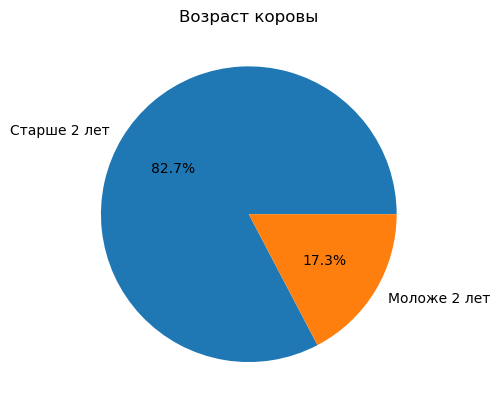

In [45]:
distribution = own_herd["is_old"].value_counts()
fig, ax = plt.subplots()
ax.pie(distribution, labels = ["Старше 2 лет", "Моложе 2 лет"], autopct="%1.1f%%")
ax.set_title("Возраст коровы")
plt.show()

Посмотрим на таблицу родителей коров в ферме.

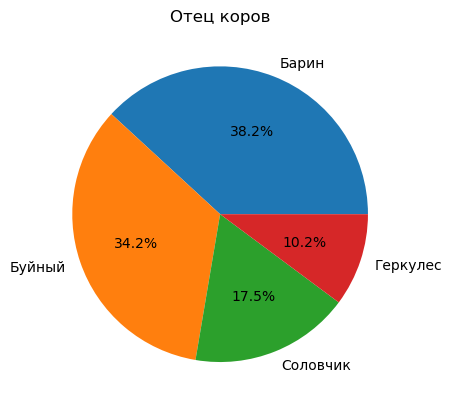

In [46]:
distribution = cows_ancestor["ancestor_name"].value_counts()
fig, ax = plt.subplots()
ax.pie(distribution, labels = distribution.index, autopct="%1.1f%%")
ax.set_title("Отец коров")
plt.show()

Ничего особенного. Далее проанализируем данные продаваемых коров.

<AxesSubplot:title={'center':'Жирность молока продаваемых коров'}, xlabel='Жирность молока, %', ylabel='Количество коров с соответствующей жирностью молока'>

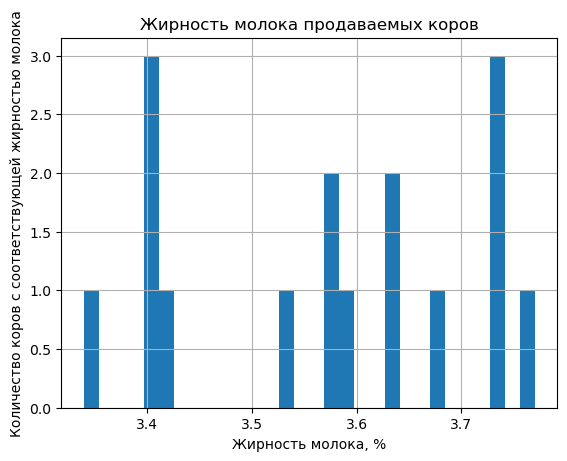

In [47]:
_, ax = plt.subplots()
ax.set_title('Жирность молока продаваемых коров')
ax.set_xlabel("Жирность молока, %")
ax.set_ylabel("Количество коров с соответствующей жирностью молока")
sale_herd["fatness"].hist(bins=30)

Заметно, что у большего количества продаваемых коров жирность молока ниже средних и наиболее часто встречаемых значений стада фермера. 

<AxesSubplot:title={'center':'Количество белка в молоке продаваемых коров'}, xlabel='Белок, %', ylabel='Количество коров с соответствующим содержанием белка в молоке'>

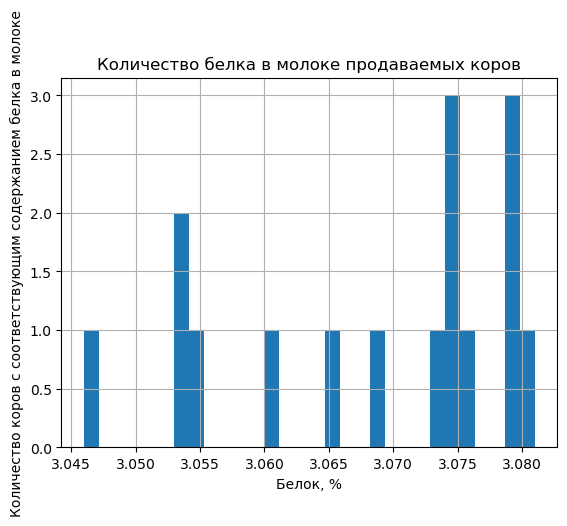

In [48]:
_, ax = plt.subplots()
ax.set_title('Количество белка в молоке продаваемых коров')
ax.set_xlabel("Белок, %")
ax.set_ylabel("Количество коров с соответствующим содержанием белка в молоке")
sale_herd["proteins"].hist(bins=30)

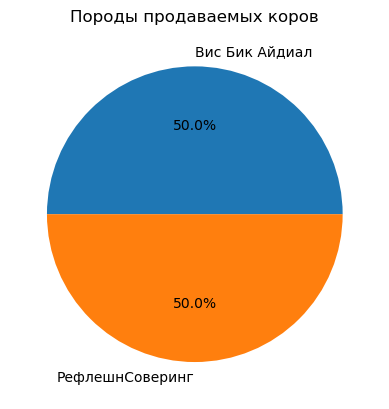

In [49]:
distribution = sale_herd["breed"].value_counts()
fig, ax = plt.subplots()
ax.pie(distribution, labels = distribution.index, autopct="%1.1f%%")
ax.set_title("Породы продаваемых коров")
plt.show()

Продаётся одинаковое количество коров с двумя разными породами.

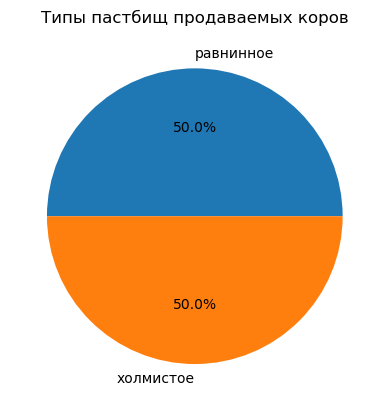

In [50]:
distribution = sale_herd["pasture_type"].value_counts()
fig, ax = plt.subplots()
ax.pie(distribution, labels = distribution.index, autopct="%1.1f%%")
ax.set_title("Типы пастбищ продаваемых коров")
plt.show()

Продаётся одинаковое количество коров пасущихся на двух разных типах пастбищ.

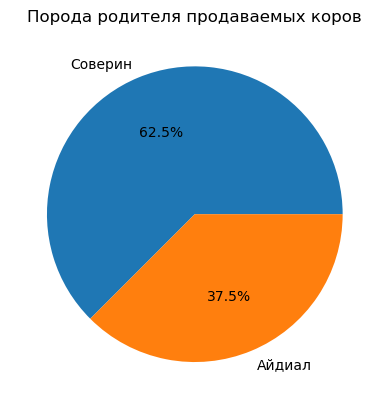

In [51]:
distribution = sale_herd["ancestor_breed"].value_counts()
fig, ax = plt.subplots()
ax.pie(distribution, labels = distribution.index, autopct="%1.1f%%")
ax.set_title("Порода родителя продаваемых коров")
plt.show()

Большинство продаваемых коров породы Соверин.

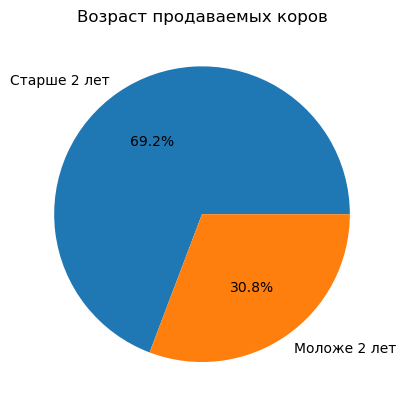

In [52]:
distribution = sale_herd["is_old"].value_counts()
fig, ax = plt.subplots()
ax.pie(distribution, labels = ["Старше 2 лет", "Моложе 2 лет"], autopct="%1.1f%%")
ax.set_title("Возраст продаваемых коров")
plt.show()

В стаде продаваемых коров чуть больше молодых, с возрастом менее двух лет.

Распределение насыщенности белком молока продаваемых коров отличается от коров из стада фермера. Выборка меньше и содержит около половины коров с содержанием белка в молоке ниже, чем в стаде фермера.

В численных признаках коров фермера были устранены выбросы, в категориальных унифицированы классы.

При анализе сахоро-протеинового соотношения коров фермера было выявлено три группы коров по этому признаку. Дальнейший анализ показал что низкая и средняя питательность корма негативно влияет на целевые признаки надоя и вкуса молока.

Жирность молока коров фермера, похоже, распределена логнормально.

Количество белка в молоке коров фермера, похоже, распределено нормально.

Странным является факт, что частоты распределения родителя коров фермера и их породы различаются на 8.5%. В дальнейшем стоит постараться найти ответ, почему.

Большинство коров фермера в стаде взрослые, т.е. старше двух лет.

Для количественных данных имеет нужно провести стандартизацию признаков в ходе подготовки данных к обучению модели.

## Корреляционный анализ

Для начала построим кореляционную матрицу в виде тепловой карты.

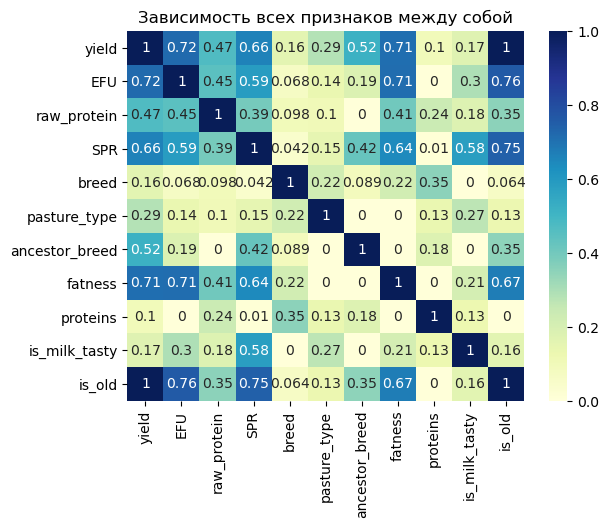

In [53]:
ax = plt.axes()
phi_k = own_herd.drop("id", axis = 1).phik_matrix(interval_cols = ["yield", "EFU", "raw_protein", "SPR", "fatness", "proteins"])
sns.heatmap(phi_k, cmap = "YlGnBu", annot = True)
ax.set_title('Зависимость всех признаков между собой')
plt.show()

Целевые признаки:
1) Надой:
    - сильно влияют на надой:
        - возраст (старше 2 лет) коровы дают молоко
        - питательности корма (EFU)
        - жирность молока
        - сахаро-протеиновое соотношение корма
    - средне влияет на надой:
        - порода отца коровы
        - количество белков в корме коровы
    - незначительно влияют на надой:
        - тип пастбища
        - вкусовые качества молока
        - порода коровы
    - почти не влияет на надой содержание белка в молоке коровы
2) Вкус молока:
    - вкус молока сильно зависит от:
        - сахаро-протеинового соотношения корма
    - в средней степени зависит от:
        - питательности корма (EFU)
        - тип пастбища
        - жирность молока
    - почти не влияют:
        - содержание белка в корме
        - надой
        - возраст (старше 2 лет) коровы
        - насыщенность молока белком
    - совершенно не влияют:
        - порода отца коровы
        - порода коровы

Зависимость признаков между собой:
- возраст коровы и питательность её корма
- жирность молока и питательность корма
- питательность корма и сахаро-протеинового соотношение корма
- возраст коровы и сахаро-протеинового соотношение корма
- сахаро-протеинового соотношение корма и возраст коровы
- жирность молока от возраста коровы


Делаем вывод, что для предсказания вкуса молока можно не использовать признаки, касающиеся породы коровы. Так же полезно рассмотреть типы зависимости для признаков с высокой и средней зависимостью с целевыми и так же построить зависимости выделенных выше прогнозных признаков между собой.

Построим наглядно зависимости целевых признаков от прогнозных.

In [54]:
print(phi_k.index)

Index(['yield', 'EFU', 'raw_protein', 'SPR', 'breed', 'pasture_type',
       'ancestor_breed', 'fatness', 'proteins', 'is_milk_tasty', 'is_old'],
      dtype='object')


In [57]:
def get_cmap(n, name='hsv'):
    '''Returns a function that maps each index in 0, 1, ..., n-1 to a distinct 
    RGB color; the keyword argument name must be a standard mpl colormap name.'''
    return plt.cm.get_cmap(name, n)

print(get_cmap(len(data)))

{'xkcd:cloudy blue': '#acc2d9', 'xkcd:dark pastel green': '#56ae57', 'xkcd:dust': '#b2996e', 'xkcd:electric lime': '#a8ff04', 'xkcd:fresh green': '#69d84f', 'xkcd:light eggplant': '#894585', 'xkcd:nasty green': '#70b23f', 'xkcd:really light blue': '#d4ffff', 'xkcd:tea': '#65ab7c', 'xkcd:warm purple': '#952e8f', 'xkcd:yellowish tan': '#fcfc81', 'xkcd:cement': '#a5a391', 'xkcd:dark grass green': '#388004', 'xkcd:dusty teal': '#4c9085', 'xkcd:grey teal': '#5e9b8a', 'xkcd:macaroni and cheese': '#efb435', 'xkcd:pinkish tan': '#d99b82', 'xkcd:spruce': '#0a5f38', 'xkcd:strong blue': '#0c06f7', 'xkcd:toxic green': '#61de2a', 'xkcd:windows blue': '#3778bf', 'xkcd:blue blue': '#2242c7', 'xkcd:blue with a hint of purple': '#533cc6', 'xkcd:booger': '#9bb53c', 'xkcd:bright sea green': '#05ffa6', 'xkcd:dark green blue': '#1f6357', 'xkcd:deep turquoise': '#017374', 'xkcd:green teal': '#0cb577', 'xkcd:strong pink': '#ff0789', 'xkcd:bland': '#afa88b', 'xkcd:deep aqua': '#08787f', 'xkcd:lavender pink': 

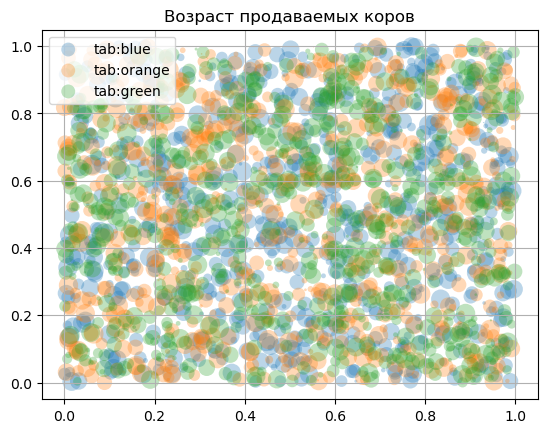

In [56]:
fig, ax = plt.subplots()
for color in ['tab:blue', 'tab:orange', 'tab:green']:
    n = 750
    x, y = np.random.rand(2, n)
    scale = 200.0 * np.random.rand(n)
    ax.scatter(x, y, c=color, s=scale, label=color,
               alpha=0.3, edgecolors='none')

ax.legend()
ax.grid(True)
ax.set_title("Возраст продаваемых коров")
plt.show()

## Обучение модели линейной регрессии

## Обучение модели логистической регрессии

## Итоговые выводы